In [1]:
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install -U scikit-learn

     |████████████████████████████████| 6.6 MB 7.2 MB/s eta 0:00:01
  Using cached spacy_legacy-3.0.12-py2.py3-none-any.whl (29 kB)
  Using cached pathy-0.10.1-py3-none-any.whl (48 kB)
  Using cached wasabi-1.1.1-py3-none-any.whl (27 kB)
     |████████████████████████████████| 3.2 MB 28.4 MB/s eta 0:00:01
  Using cached murmurhash-1.0.9-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (21 kB)
  Using cached langcodes-3.3.0-py3-none-any.whl (181 kB)
  Using cached srsly-2.4.6-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (491 kB)
  Using cached typer-0.7.0-py3-none-any.whl (38 kB)
  Using cached cymem-2.0.7-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (35 kB)
  Using cached smart_open-6.3.0-py3-none-any.whl (56 kB)
  Using cached thinc-8.1.9-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (922 kB)
  Using cached catalogue-2.0.8-py3-none-any.whl (17 kB)
  Using cached preshed-3.0.8-cp39-cp39-manylinux_2_5_x86_

In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from collections import defaultdict 
import spacy
import en_core_web_sm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.mixture import GaussianMixture
import re
from collections import Counter 

2023-04-14 17:56:35.691445: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/pkgs/cudatoolkit-11.2.2-he111cf0_8/lib/:
2023-04-14 17:56:35.691514: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-14 17:56:35.691553: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dsmlp-jupyter-smodafferi): /proc/driver/nvidia/version does not exist


In [22]:
raw = pd.read_csv('ted_talks_en.csv')

In [23]:
arr = raw['topics'].to_numpy()
keywords = defaultdict(int)
for i, inner in enumerate(arr):
    x = inner.split("'")
    for i, tag in enumerate(x):
        if i % 2 != 0 and i != 0 and i != len(x) - 1:
            keywords[tag.lower()] += 1

In [24]:
most_common_keywords = sorted(list(keywords.keys()), key=lambda keyword: keywords[keyword])[::-1]
occurences = [keywords[keyword] for keyword in most_common_keywords]
#list(zip(most_common_keywords, occurences))

(array([176., 103.,  45.,  31.,  25.,  10.,  10.,  10.,   7.,   3.,   5.,
          6.,   2.,   2.,   1.,   1.,   3.,   2.,   1.,   2.,   1.,   0.,
          2.,   0.,   1.,   2.,   0.,   1.,   2.,   1.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.]),
 array([  0,  20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 220, 240,
        260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 460, 480, 500,
        520, 540, 560, 580, 600, 620, 640, 660, 680, 700, 720, 740, 760,
        780, 800, 820, 840, 860, 880, 900, 920, 940, 960, 980]),
 <BarContainer object of 49 artists>)

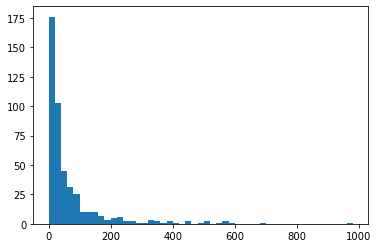

In [25]:
plt.hist(occurences, bins=np.arange(0, 1000, 20))

In [26]:
cutoff = 50
y = filter(lambda x: x >= cutoff, occurences)
print(f"Amount of topics with occurences >= {cutoff} : {len(list(y))}")

Amount of topics with occurences >= 50 : 156


In [27]:
def convert_topics(topic):
    x = topic.split("'")
    tags = []
    for i, tag in enumerate(x):
        if i % 2 != 0 and i != 0 and i != len(x) - 1:
            tags.append(tag.lower())
    return tags

def correct_dataframe_topics_column(df, in_place=False):
    if not in_place:
        df = df.copy()
    topics_listed_column = df['topics'].apply(convert_topics)
    df['topics'] = topics_listed_column
    return df

In [28]:
"""
Topics of focus:
STEM - Science, Technology, Engineering, Math(Mathematics), Psychology, Physics, Biotech, AI, Cognitive Science
Culture - Culture, Society, Community
Business - Business, Economics
Social Change - social change/activism
History - History/Politics
"""
topic_to_group = defaultdict(lambda: 'not-relevant')
stem = ["science", "technology", "engineering", "math", "mathematics", "psychology", "physics", "biotech", "ai", "cognitive science", 'math', 'computers', 'science', 'software', 'technology', 'visualizations', 'health']
culture = ["culture", "society", "community", 'culture', 'humor', 'visualizations', 'children', 'creativity', 'entertainment', 'media', 'education', 'parenting', 'teaching', 'collaboration', 'music', 'performance', 'activism', 'africa', 'inequality', 'politics']
business = ["business", "economics",  'design', 'comedy', 'storytelling', 'entertainment', 'media', 'business', 'cities', 'demo', 'economics']
activism = ['social change', 'activism',  'climate change', 'environment', 'global issues', 'sustainability', 'green', 'inequality', 'global development', 'pollution']
history = ['history', 'politics',  'creativity', 'architecture', 'religion', 'storytelling']
categories = [ ['stem'] + stem, ['culture'] + culture, ['business'] + business,
              ['activism'] + activism, ['history'] + history]

for category in categories:
    cat = None
    for i, topic in enumerate(category):
        if i == 0:
            cat = topic
            continue
        topic_to_group[topic] = cat

In [29]:
def group_topics(topic_list):
    grouped = set()
    for topic in topic_list:
        grouped.add(topic_to_group[topic])
    if len(grouped) > 1 and 'not-relevant' in grouped:
        grouped.remove('not-relevant')
    return grouped

def group_df_topics(df, in_place=False):
    if not in_place:
        df = df.copy()
    df['grouped_topics'] = df['topics'].apply(group_topics)
    return df

In [30]:
def count_unique_words(script): 
    unique_words = dict()
    script_lst = script.split()
    for word in script_lst: 
        if word in unique_words: 
            unique_words[word] += 1
        else: 
            unique_words[word] = 1
    return unique_words

def add_words(df, in_place=False):
    if in_place:
        df = df.copy()
    df["clean_scripts"] = (
    df["transcript"]
    .str.replace(r'\(Music: [^)]+\) ','', regex = True)
    .str.replace(r' — ', ' ', regex = True)
    .str.replace(r'[[."\'!\],:?;=+*&]', '', regex = True)
    .str.lower())
    df["words"] = df["clean_scripts"].apply(count_unique_words)
    return df

In [31]:
def one_hot_encode(df: pd.DataFrame, verbose=False, in_place=False):
    """
    expects df to have a columns ['words'] which contains a dictionary for each entry,
    this dictionary has all the unique words in this row's transcript as keys, and their values
    correspond the amount of time that word appears in the transcript. This creates 
    """
    word_dicts = df['words'].to_numpy()
    total_dict = defaultdict(int)
    total_count = 0
    for word_dict in word_dicts:
        for word in word_dict.keys():
            total_dict[word] += word_dict[word]
            total_count += word_dict[word]
    unique_count = len(list(total_dict.keys()))
    if verbose: 
        print("Amount of unique words: {:,}".format(unique_count), 
             "\nTotal word count: {:,}".format(total_count))
    
    word_to_onehot_location = {}
    for i, word in enumerate(list(total_dict.keys())):
        word_to_onehot_location[word] = i
        
    new_col = []
    for i, row in enumerate(word_dicts):
        new_entry = np.zeros(unique_count, dtype=int)
        for word in row:
            new_entry[word_to_onehot_location[word]] = 1
        new_col.append(new_entry)
    if in_place:
        new_df = df
    else:
        new_df = df.copy()
    new_df['one-hot'] = new_col
    return new_df

def sentence_type(df, in_place=False):
    """
    adds an array to each row
    this array contains the frequency of each setence type
    arr[0] = . | arr[1] = ? | arr[2] = !
    each entry is total occurences / total punctuation count
    """
    new_col = []
    for transcript in df['transcript']:
        new_entry = np.zeros(3)
        p_count, q_count, e_count = transcript.count('.'), transcript.count('?'), transcript.count('!')
        total_sentences = p_count + q_count + e_count + 1
        new_entry[0] = (p_count + 1)/ total_sentences
        new_entry[1] = (q_count + 1)/ total_sentences
        new_entry[2] = (e_count + 1)/ total_sentences
        new_col.append(new_entry)
    if in_place:
        new_df = df
    else:
        new_df = df.copy()
    new_df['sentence-type'] = new_col
    return new_df


In [32]:
## TFIDF Calculation
def tfidf_value(transcript):
    tfIdfVectorizer = TfidfVectorizer(use_idf=True)
    tfIdf = tfIdfVectorizer.fit_transform([transcript])
    #list_of_words_tfidf = tfIdfVectorizer.get_feature_names_out()
    tfidf_value = tfIdf.toarray()[0]
    return tfidf_value

def tfidf_words(transcript):
    tfIdfVectorizer = TfidfVectorizer(use_idf=True)
    tfIdf = tfIdfVectorizer.fit_transform([transcript])
    try:
        list_of_words_tfidf = tfIdfVectorizer.get_feature_names_out()
    except Error:
        list_of_words_tfidf = tfIdfVectorizer.get_feature_names()
    tfidf_words = list_of_words_tfidf
    return tfidf_words

def tfidf_dict(transcript):
    tfIdfVectorizer = TfidfVectorizer(use_idf=True)
    tfIdf = tfIdfVectorizer.fit_transform([transcript])
    try:
        list_of_words_tfidf = tfIdfVectorizer.get_feature_names_out()
    except Error:
        list_of_words_tfidf = tfIdfVectorizer.get_feature_names()
    tfidf_value = tfIdf.toarray()[0]
    tfidf_dict = dict(zip(list_of_words_tfidf,tfidf_value))
    return tfidf_dict

def add_tfidf(df: pd.DataFrame, in_place=False):
    if in_place:
        df = df.copy()
    df['tfidf'] = df['transcript'].apply(tfidf_value)
    df['tfidf_word'] = df['transcript'].apply(tfidf_words)
    df['tfidf_dict'] = df['transcript'].apply(tfidf_dict)
    return df

In [33]:
def get_feature_engineered():
    data = raw.copy()
    data = correct_dataframe_topics_column(data, in_place=True)
    data = group_df_topics(data, in_place=True)
    data = add_words(data, in_place=True)
    data = one_hot_encode(data, in_place=True)
    data = sentence_type(data, in_place=True)
    data = add_tfidf(data, in_place=True)
    data = data.drop(columns = [
    "talk_id", "speaker_1", "views", "recorded_date", "published_date", 
    "event", "duration", "url", "comments", "about_speakers", 
    "available_lang", "all_speakers", "native_lang"])
    return data

In [ ]:
data = get_feature_engineered()

In [ ]:
df_count = pd.Series(keywords).to_frame().reset_index().rename(columns = {"index": "category", 0:"count"})

df_count = df_count[df_count["count"] >= 50]
total_count = df_count.shape[0]

lst = []
for i in range(0, total_count, 39):
    df_cut = df_count.iloc[i: i+ 39]
    lst.append(df_cut)

In [ ]:
lst[0]